In [1]:
import torch

import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision
import matplotlib.pyplot as plt

from network import *
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
bs=100
# MNIST Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [3]:
 #build network
z_dim = 100
G = Generator().to(device)
D = Net().to(device)

In [4]:
D

Net(
  (encoder): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Upsample(scale_factor=2.0, mode=bilinear)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
  )

In [5]:
D(torch.rand(2,1,28,28,device=device)).shape

C:\Users\admin\anaconda3\envs\Singan\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([2, 1, 28, 28])

In [6]:
gamma = 0.75
lambda_k = 0.001
k = 0.0

In [7]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.00005 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [8]:
def calc_gradient_penalty(netD, real_data, fake_data, LAMBDA,device='cpu'):
    alpha = torch.rand(1, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)#.cuda()
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)
    disc_interpolates = netD(interpolates)
    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),#.cuda(), #if use_cuda else torch.ones(
                                  #disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [9]:
def D_train(x):
    D.zero_grad()
    bs = x.shape[0]
    
    # train discriminator on real
    x_real, y_real = x, torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    d_real  = D(x_real)

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim,1,1).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    d_fake  = D(x_fake.detach())

    
    d_loss_real = torch.mean(torch.abs(d_real - x_real))
    d_loss_fake = torch.mean(torch.abs(d_fake - x_fake.detach()))
    d_loss = d_loss_real - k * d_loss_fake
    



    d_loss.backward()
    D_optimizer.step()
        
    return  d_loss.item(),d_loss_real.detach(),d_loss_fake.detach()

In [10]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()
    bs = x.shape[0]
    z = Variable(torch.randn(bs, z_dim,1,1).to(device))
    G_output = G(z)
    g_loss = torch.mean(torch.abs(D(G_output) - G_output))

    g_loss.backward()
    G_optimizer.step()
        
    return g_loss.item(),G_output.detach()


C:\Users\admin\anaconda3\envs\Singan\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


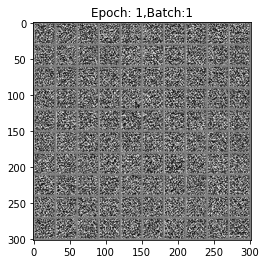

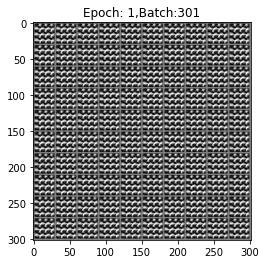

[1/20]: loss_d: 0.198, loss_g: 0.225


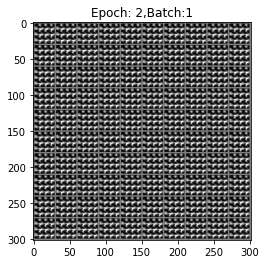

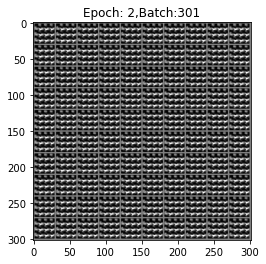

[2/20]: loss_d: 0.127, loss_g: 0.166


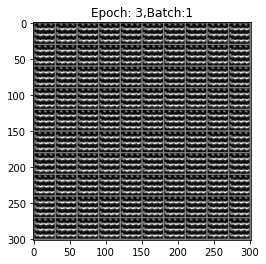

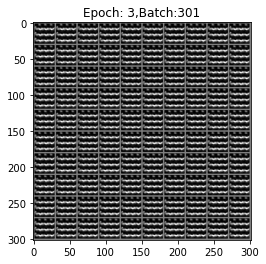

[3/20]: loss_d: 0.099, loss_g: 0.141


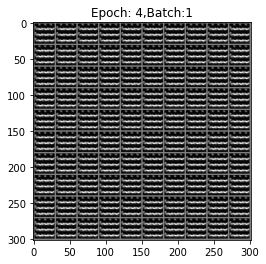

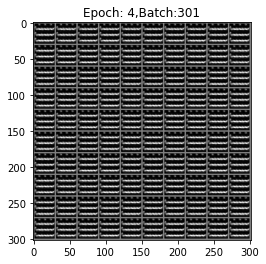

[4/20]: loss_d: 0.084, loss_g: 0.125


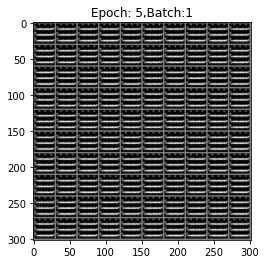

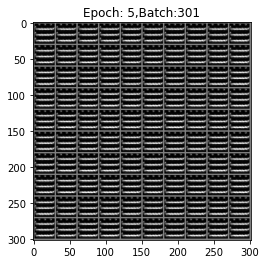

[5/20]: loss_d: 0.074, loss_g: 0.114


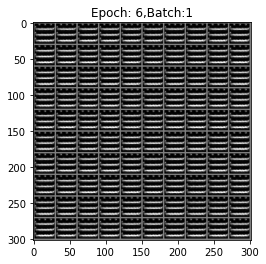

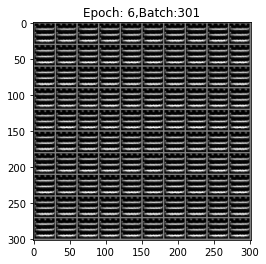

[6/20]: loss_d: 0.067, loss_g: 0.105


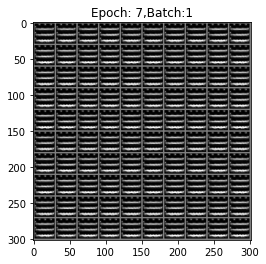

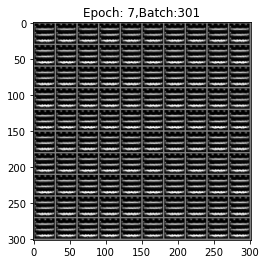

[7/20]: loss_d: 0.062, loss_g: 0.097


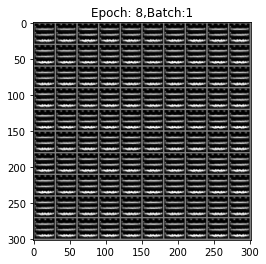

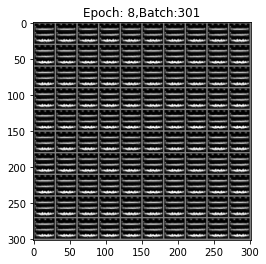

[8/20]: loss_d: 0.058, loss_g: 0.091


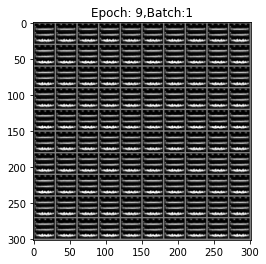

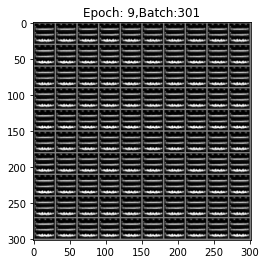

[9/20]: loss_d: 0.055, loss_g: 0.085


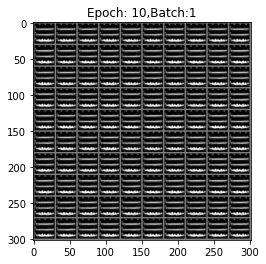

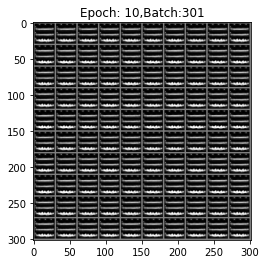

[10/20]: loss_d: 0.052, loss_g: 0.080


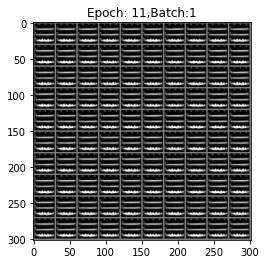

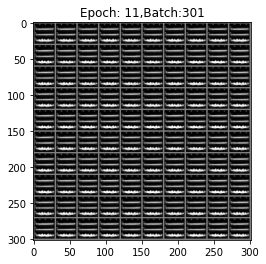

[11/20]: loss_d: 0.050, loss_g: 0.076


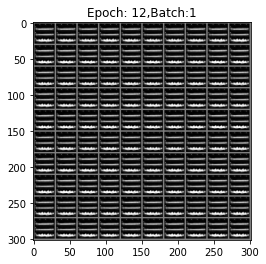

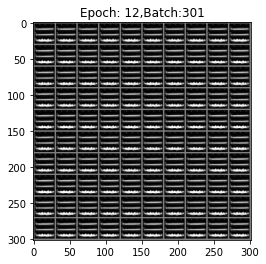

[12/20]: loss_d: 0.048, loss_g: 0.072


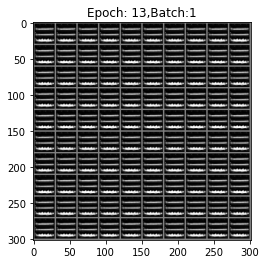

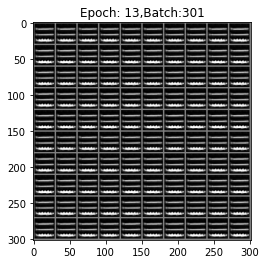

[13/20]: loss_d: 0.046, loss_g: 0.068


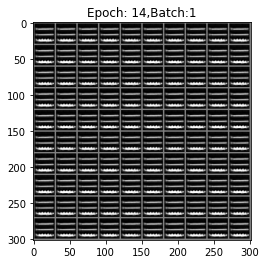

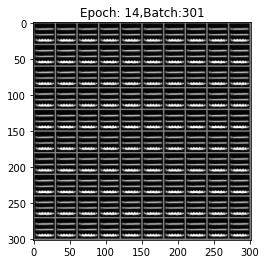

[14/20]: loss_d: 0.045, loss_g: 0.065


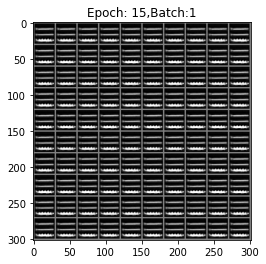

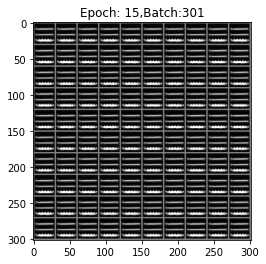

[15/20]: loss_d: 0.043, loss_g: 0.062


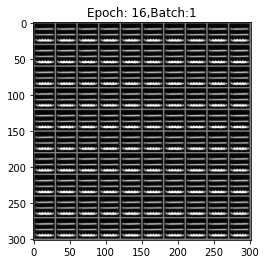

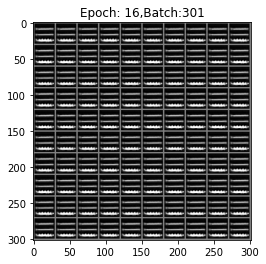

[16/20]: loss_d: 0.042, loss_g: 0.059


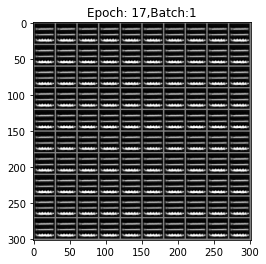

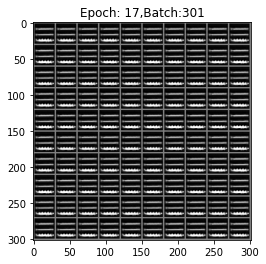

[17/20]: loss_d: 0.041, loss_g: 0.057


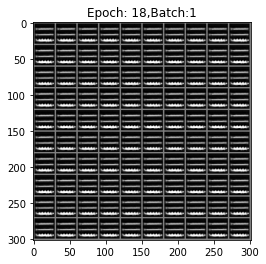

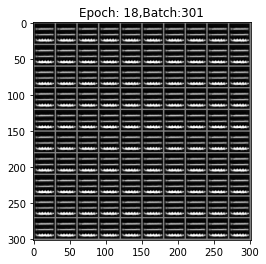

[18/20]: loss_d: 0.040, loss_g: 0.055


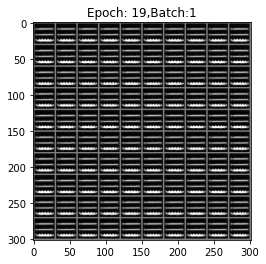

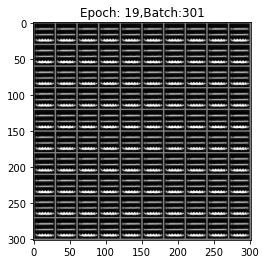

[19/20]: loss_d: 0.039, loss_g: 0.053


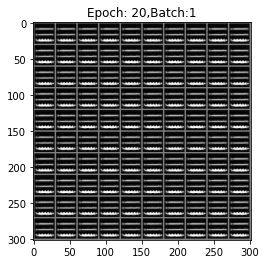

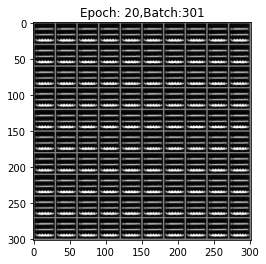

[20/20]: loss_d: 0.038, loss_g: 0.051


In [11]:
n_epoch = 20
Ms=[]
D_losses, G_losses = [], []
for epoch in range(1, n_epoch+1):           
    for batch_idx, (x, _) in enumerate(train_loader):

        D_loss,d_re,d_fa=D_train(x)
        D_losses.append(D_loss)
        G_loss,gen_data=G_train(x)

        diff=gamma*d_re-d_fa
        k=k+lambda_k*diff
        k=min(max(k,0),1)
        
        M=(d_re+abs(diff))
        Ms.append(M)
        G_losses.append(G_loss)
        if batch_idx %300 ==0:
            gen_data=gen_data.view(100,1,28,28)
            grid_img = torchvision.utils.make_grid(gen_data, nrow=10)
            plt.figure()
            plt.title(f"Epoch: {epoch},Batch:{batch_idx+1}")
            plt.imshow(grid_img.cpu().permute(1,2,0)*0.5+0.5)
            plt.show()

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

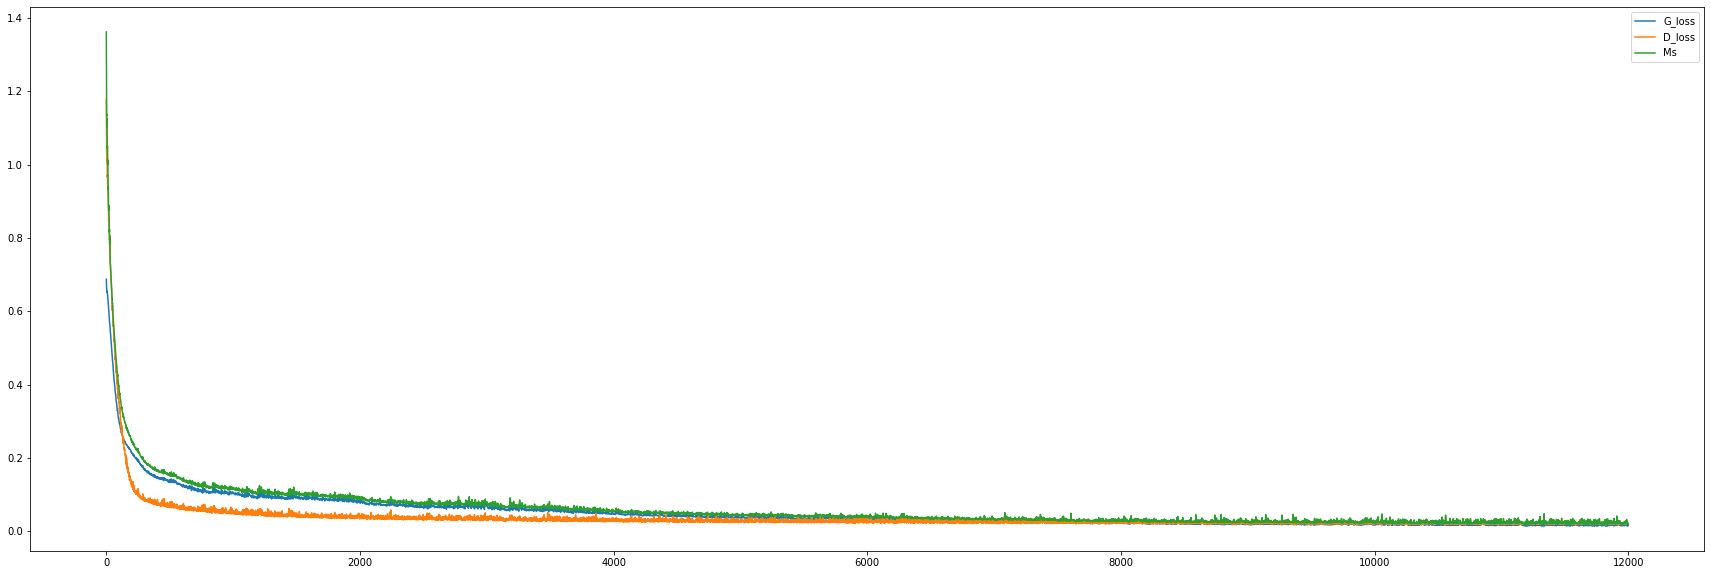

In [12]:
plt.figure(figsize=(30,10))
plt.plot(G_losses,label='G_loss')
plt.plot(D_losses,label='D_loss')
plt.plot(Ms,label='Ms')

plt.legend()

#plt.legend("D_losses")


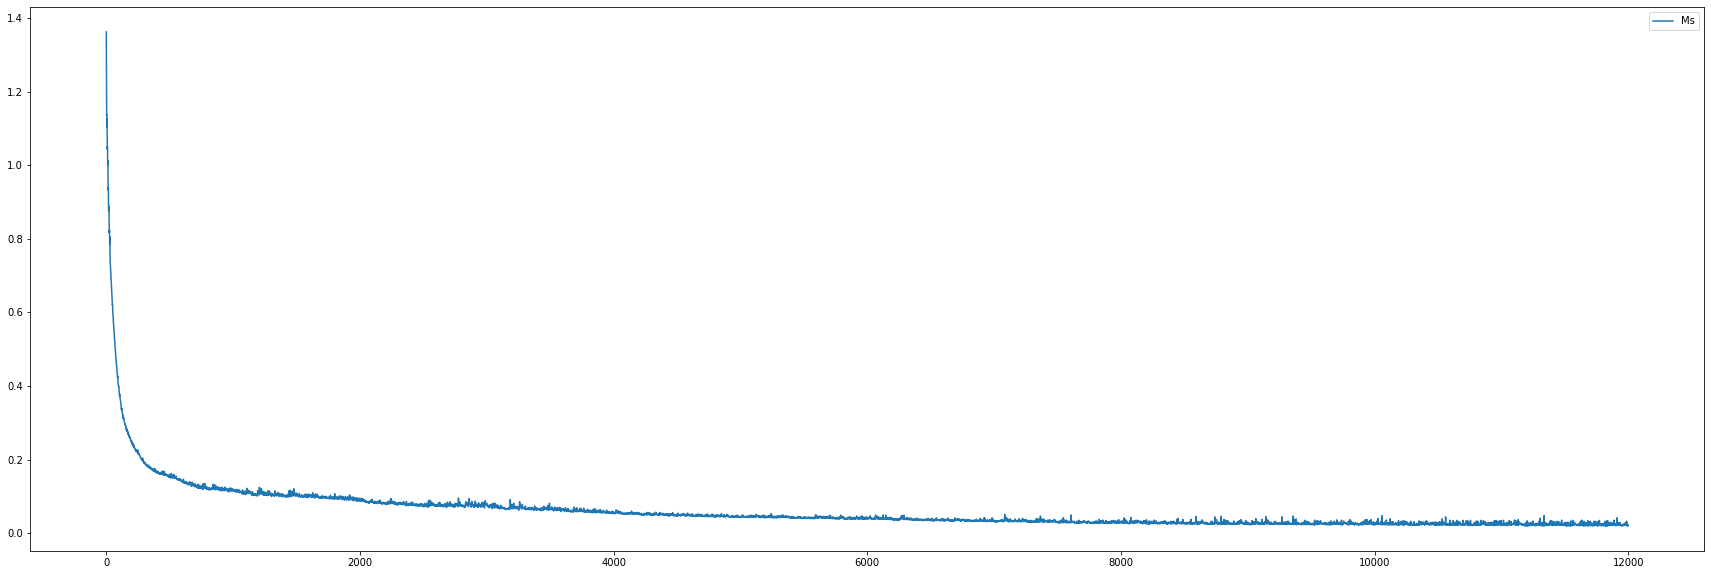

In [14]:
plt.figure(figsize=(30,10))
plt.plot(Ms,label='Ms')
plt.legend()

#plt.legend("D_losses")
